In [1]:
import os
import sys
import subprocess
import shutil
import pickle

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
import Hyperbolic as hyp

# AP code

In [2]:
def find_component(node, connected_components):
    for i, component in enumerate(connected_components):
        if node in component:
            return i
    raise ValueError(f'Component for node {node} not found')

In [3]:
def cascade_remove_links(G):
    keep_going = True
    while keep_going:
        keep_going = False

        clusters_in_layers = [list(nx.connected_components(g)) for g in G]

        for i, g in enumerate(G):
            clusters_to_search = clusters_in_layers[:i] + clusters_in_layers[i + 1:]
            for edge in g.edges():
                if any(find_component(edge[0], clusters) != find_component(edge[1], clusters)
                       for clusters in clusters_to_search):
                    keep_going = True
                    g.remove_edge(*edge)
    
    return G

In [4]:
def articulation_points_multiplex(G):
    ap = set(nx.articulation_points(G[0]))
    return ap.union(*[nx.articulation_points(g) for g in G[1:]])

In [5]:
def max_comp(g):
    return max(nx.connected_components(g), key=len)

In [6]:
def remove_ap(G):
    G = cascade_remove_links(G)

    gcc = max_comp(G[0])
    gcc_size = len(gcc)

    for g in G:
        g.remove_nodes_from([n for n in g if n not in gcc])

    art_points = articulation_points_multiplex(G)

    for g in G:
        g.remove_nodes_from(art_points)

    return G, art_points, gcc_size

# Experiment

In [7]:
kbar = 4.
gamma = 3.
T = .4
N = 50000
nruns = 10
g = 1.
nu = 1.

In [9]:
def generate(N, kbar, gamma, T, g, nu, seed):
    np.random.seed(seed)

    kmin1 = hyp.CalculateKmin(kbar, gamma)
    C1 = hyp.CalculateC(kbar, T, gamma)
    R1 = hyp.CalculateR(N, C1)

    kmin2 = hyp.CalculateKmin(kbar, gamma)
    C2 = hyp.CalculateC(kbar, T, gamma)
    R2 = hyp.CalculateR(N, C2)

    kappa1 = hyp.SampleKappa(N, kmin1, gamma)
    kappa2 = hyp.SampleConditionalKappa(N, nu, kappa1[:], kmin1, gamma, kmin2, gamma)

    theta1 = hyp.SampleTheta(N)
    theta2 = hyp.SampleConditionalTheta(N, g, theta1[:])

    r1 = hyp.ChangeVariablesFromS1ToH2(N, kappa1[:], R1, kmin1)
    r2 = hyp.ChangeVariablesFromS1ToH2(N, kappa2[:], R2, kmin2)

    hyp.PrintCoordinates(r1[:], theta1[:], kappa1[:], 'coords1.txt')
    hyp.PrintCoordinates(r2[:], theta2[:], kappa2[:], 'coords2.txt')

    subprocess.call(['hyperb.exe', 'coords1.txt', str(seed), str(N), str(kbar), str(T)])
    links1 = hyp.ReadLinks('links.coords1.txt')

    subprocess.call(['hyperb.exe', 'coords2.txt', str(seed + 1), str(N), str(kbar), str(T)])
    links2 = hyp.ReadLinks('links.coords2.txt')
    return nx.Graph(links1), nx.Graph(links2), np.array(theta1), np.array(theta2)

In [21]:
def xi_last_iteration(N, kbar, gamma, T, g, nu, seed):
    *G, theta1, theta2 = generate(N, kbar, gamma, T, g, nu, seed)
    while True:
        G = cascade_remove_links(G)
        gcc = max_comp(G[0])
        for g in G:
            g.remove_nodes_from([n for n in g if n not in gcc])
        art_points = articulation_points_multiplex(G)
        for g in G:
            g.remove_nodes_from(art_points)
        if not art_points:
            break
    return abs(np.exp(1j * theta[list(gcc)]).sum())

In [19]:
plt.rc('text', usetex=True)
plt.rc('font', size=30, **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rcParams['xtick.major.pad'] = 8
plt.rcParams['ytick.major.pad'] = 8
plt.rcParams['savefig.bbox'] = 'tight'
%matplotlib inline

colors = [
    '#1abc9c',  # turquoise
    '#9b59b6',  # amethyst
    '#34495e',  # wet asphalt
    '#2980b9',  # belize hole
    '#f1c40f',  # sun flower
    '#e74c3c',  # alizarin
    '#7f8c8d',  # asbestos
]

In [20]:
# kbars = [.1] + list(range(1, 13))
# kbars = [.1] + list(range(2, 11, 2))

kbars = np.hstack([
    [.1, 2., 4., 5.],
    np.arange(6., 8. + .05, .05),
    [9., 10., 12.],
])

In [22]:
xi_last = {}

seed = 12345
for kbar in kbars:
    xi_last[kbar] = 0.
    for _ in range(nruns):
        xi_last[kbar] += xi_last_iteration(N, kbar, gamma, T, seed)
        seed += 1
    xi_last[kbar] /= nruns

kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2480
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2506
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2552
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2521
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2598
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2397
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2462
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2291
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2405
kmin:  0.05
C:  0.029720516134223548
R:  28.671391954263257
number of links:	 2434
kmin:  1.0
C:  0.5944103226844709
R:  22.679927407155276
number of links:	 50315
kmin:  1.0
C:  0.5944103226844709
R:  22.679927407155276
number of links:	 50232
kmin:  1

In [23]:
with open('xi_last.pickle', 'wb') as f:
    pickle.dump(xi_last, f)

In [15]:
with open('xi_last.pickle', 'rb') as f:
    xi_last = pickle.load(f)

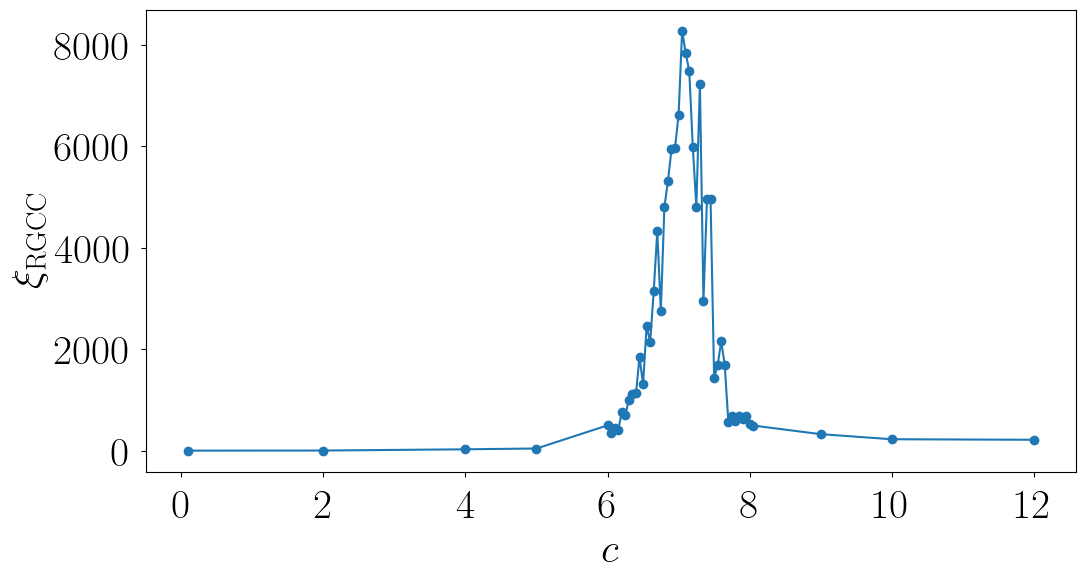

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(
    kbars,
    xi_last.values(),
    '-o',
)
plt.xlabel(r'$c$')
plt.ylabel(r'$\xi_\mathrm{RGCC}$');